# Affine Structure from Motion

In [ ]:
## Import necessary libraries here (You can add libraries you want to use here)
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

## Overview
<img src="https://drive.google.com/uc?id=1nYd0eJjBtVIPuapfxuiVzswjswGN_Gq2&export=download" width="800"/>


In this we will recover a 3D pointcloud from the image sequence hotel.seq0.png … hotel.seq50.png.

The outline of the affine structure from motion algorithm:

<img src="https://drive.google.com/uc?id=1BSvHwRR5gNBwDGlrk-dcLCRcuIAvab__&export=download" width="700"/>


## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
!unzip "/content/Part2_data.zip" -d "/content/"
# Load Matches
data = loadmat('/content/Part2_data/tracks.mat')

Downloading...
From: https://drive.google.com/uc?id=1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
To: /content/Part2_data.zip
100% 5.44M/5.44M [00:00<00:00, 101MB/s]
Archive:  /content/Part2_data.zip
   creating: /content/Part2_data/
   creating: /content/Part2_data/images/
  inflating: /content/Part2_data/images/hotel.seq0.png  
  inflating: /content/Part2_data/images/hotel.seq1.png  
  inflating: /content/Part2_data/images/hotel.seq10.png  
  inflating: /content/Part2_data/images/hotel.seq11.png  
  inflating: /content/Part2_data/images/hotel.seq12.png  
  inflating: /content/Part2_data/images/hotel.seq13.png  
  inflating: /content/Part2_data/images/hotel.seq14.png  
  inflating: /content/Part2_data/images/hotel.seq15.png  
  inflating: /content/Part2_data/images/hotel.seq16.png  
  inflating: /content/Part2_data/images/hotel.seq17.png  
  inflating: /content/Part2_data/images/hotel.seq18.png  
  inflating: /content/Part2_data/images/hotel.seq19.png  
  inflating: /content/Part2_data/images/hot

### Code

In [ ]:
track_x = data['track_x']
track_y = data['track_y']

# Remove the nan value
# YOUR CODE HERE

ind = np.argwhere(np.isnan(track_x))

unique = list(set(ind[:,0].flatten()))

x = np.delete(track_x, unique, axis=0)
y = np.delete(track_y, unique, axis=0)

In [ ]:
def normalizeSfM(x, y):

  x_new = x.copy()
  y_new = y.copy()

  for i in range(x.shape[1]):
    x_new[:,i] = x[:,i] - np.mean(x[:,i])
    y_new[:,i] = y[:,i] - np.mean(y[:,i])

  return x_new, y_new

def createMeasurementMatrix(x, y):

  D = np.array([np.block([[x[:,i]],
                          [y[:,i]]])
                  for i in range(x.shape[1])]).reshape(2 * x.shape[1], x.shape[0])

  return D

def decompose(D):
  [U,W,V] = np.linalg.svd(D)

  U = U[:,:3]
  W = np.array([[W[0],0,0],[0,W[1],0],[0,0,W[2]]])
  V = V[:3,:]

  A = U @ np.sqrt(W)
  S = np.sqrt(W) @ V

  return A, S

def cholesky(A):
  K = np.array([np.block([[ (A[i,:].reshape(A.shape[1],1) @ A[i,:].reshape(1, A.shape[1])).reshape(1,9) ],
                          [ (A[i+1,:].reshape(A.shape[1],1) @ A[i+1,:].reshape(1, A.shape[1])).reshape(1,9) ],
                          [ (A[i,:].reshape(A.shape[1],1) @ A[i+1,:].reshape(1, A.shape[1])).reshape(1,9) ]])
                  for i in range(0, A.shape[0]-1, 2)]).reshape(int(A.shape[0]*3/2), 9)
  
  b = np.array([np.block([[ 1 ],
                          [ 1 ],
                          [ 0 ]])
                  for i in range(int(A.shape[0]/2))]).reshape(int(A.shape[0]*3/2), 1)

  L = np.linalg.inv(K.T @ K) @ (K.T @ b)

  L = L.reshape((3,3))

  C = np.linalg.cholesky(L)

  return C

def normalizeV(v):
  norm = np.linalg.norm(v)
  if norm == 0: 
    return v
  return v / norm

In [ ]:
def affineSFM(x, y):
  '''
  Function: Affine structure from motion algorithm
  % Normalize x, y to zero mean
  % Create measurement matrix
  D = [xn' ; yn'];
  % Decompose and enforce rank 3
  % Apply orthographic constraints
  '''
  # YOUR CODE HERE

  x, y = normalizeSfM(x,y)

  D = createMeasurementMatrix(x, y)

  A, S = decompose(D)

  C = cholesky(A)

  A = A @ C
  X = np.linalg.inv(C) @ S

  return A, X

In [ ]:
def findCameraVectors(A):
  # Retrieving Camera Vectors from the Measurement Matrix
  vectors = [(np.cross(normalizeV(A[i+1,:]),normalizeV(A[i,:]))) for i in range(0,A.shape[0]-1,2)]
  vectors = np.array(vectors)
  vectors[:,1] = - vectors[:,1]
  return vectors

In [ ]:
def plotCameraVectors(vectors):
  # Plotting retrieved Camera vectors
  fig = plt.figure(figsize=(30, 10))
  l = ["ak - x component", "ak - y component", "ak - z component"]
  rows = 1
  columns = 3
  x_coords = range(1,vectors.shape[0]+1,1)
  for i in range(vectors.shape[1]):
    fig.add_subplot(rows, columns, i+1)
    plt.plot(x_coords,vectors[:,i])
    # plt.axis('off')
    plt.title(l[i],fontsize = 16)

In [ ]:
A , X = affineSFM(x,y)

In [ ]:
vectors = findCameraVectors(A)

### Write-up

*   Plotting the predicted 3D path of the cameras. The camera position for each frame is given by the cross product a_k = a_i x a_j. Normalize a_k to be unit length for consistent results. 3 plots, one for each dimension of a_k:

<!-- We provide the function plotSfM.m for visualizing the recovered 3D shape and camera positions in each frame. -->


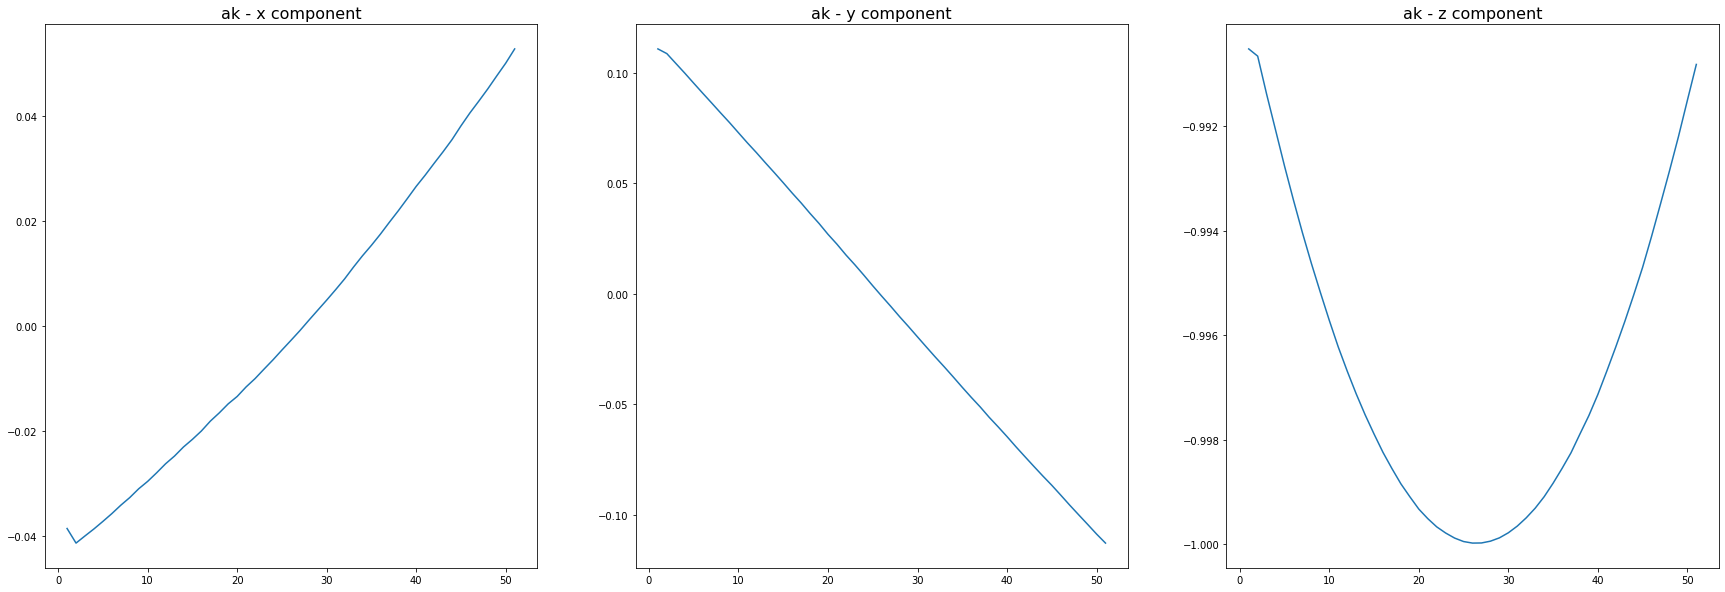

In [ ]:
plotCameraVectors(vectors)

*   Plot the predicted 3D locations of the tracked points for 3 different viewpoints. Choose the viewpoints so that the 3D structure is clearly visible.

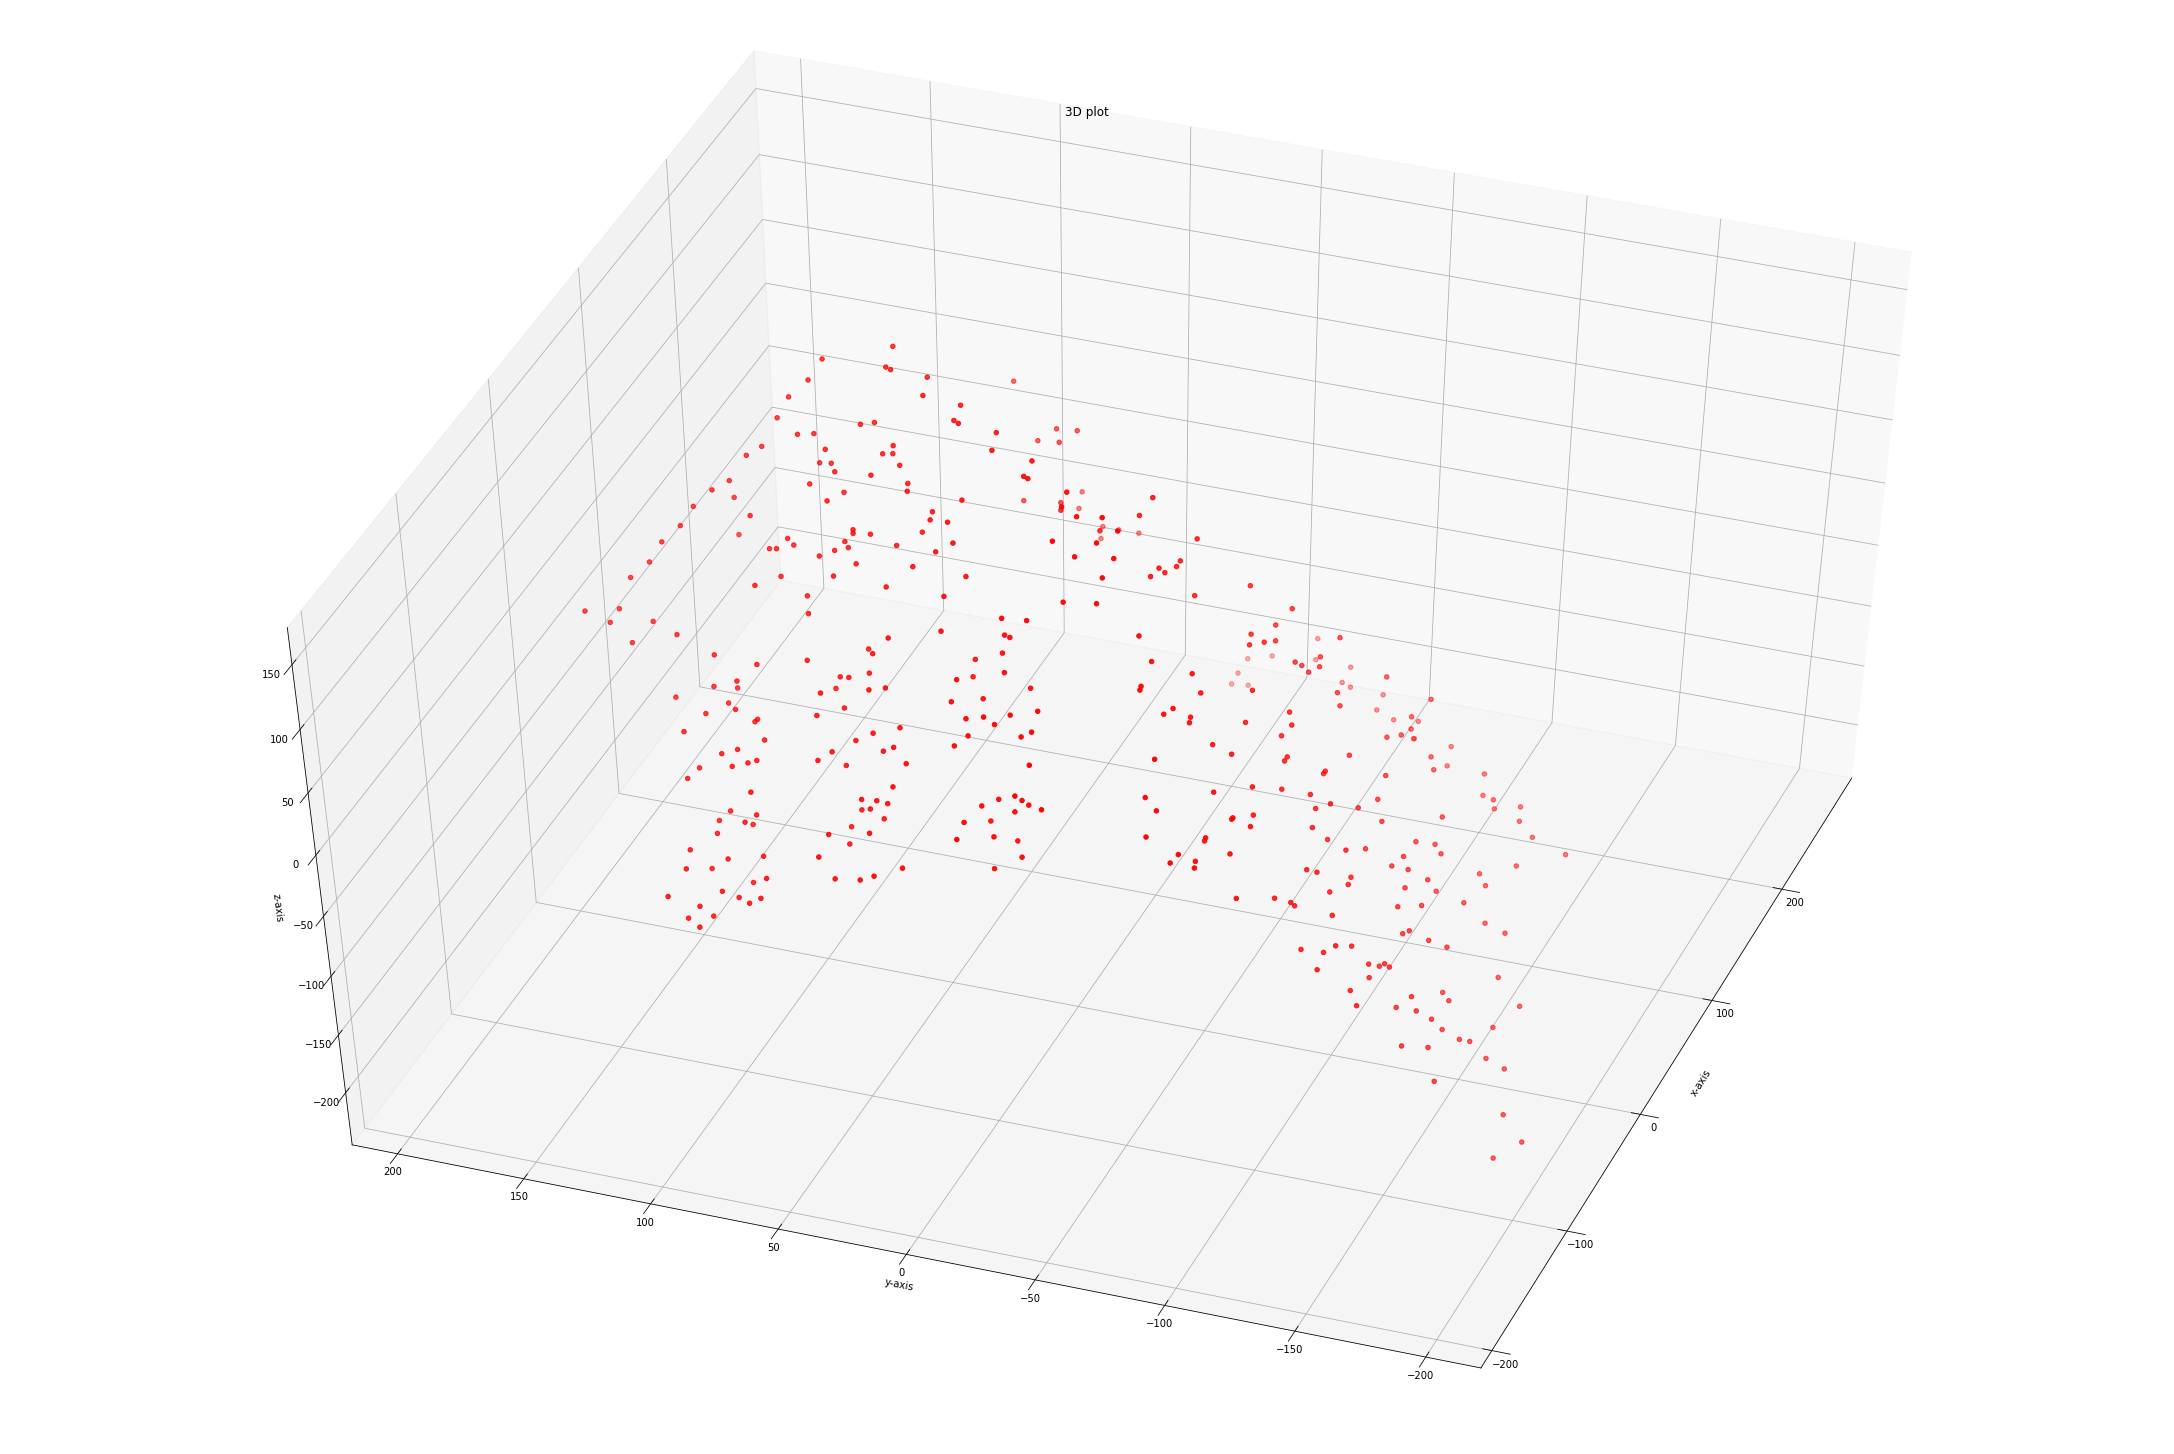

In [ ]:
# %matplotlib widget
  
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = Axes3D(fig)
  
# creating the plot
plot_ = ax.scatter(X[0,:], X[1,:], X[2,:], color='red')

ax.set_title("3D plot")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
ax.view_init(azim = -160, elev = 50)
plt.show()

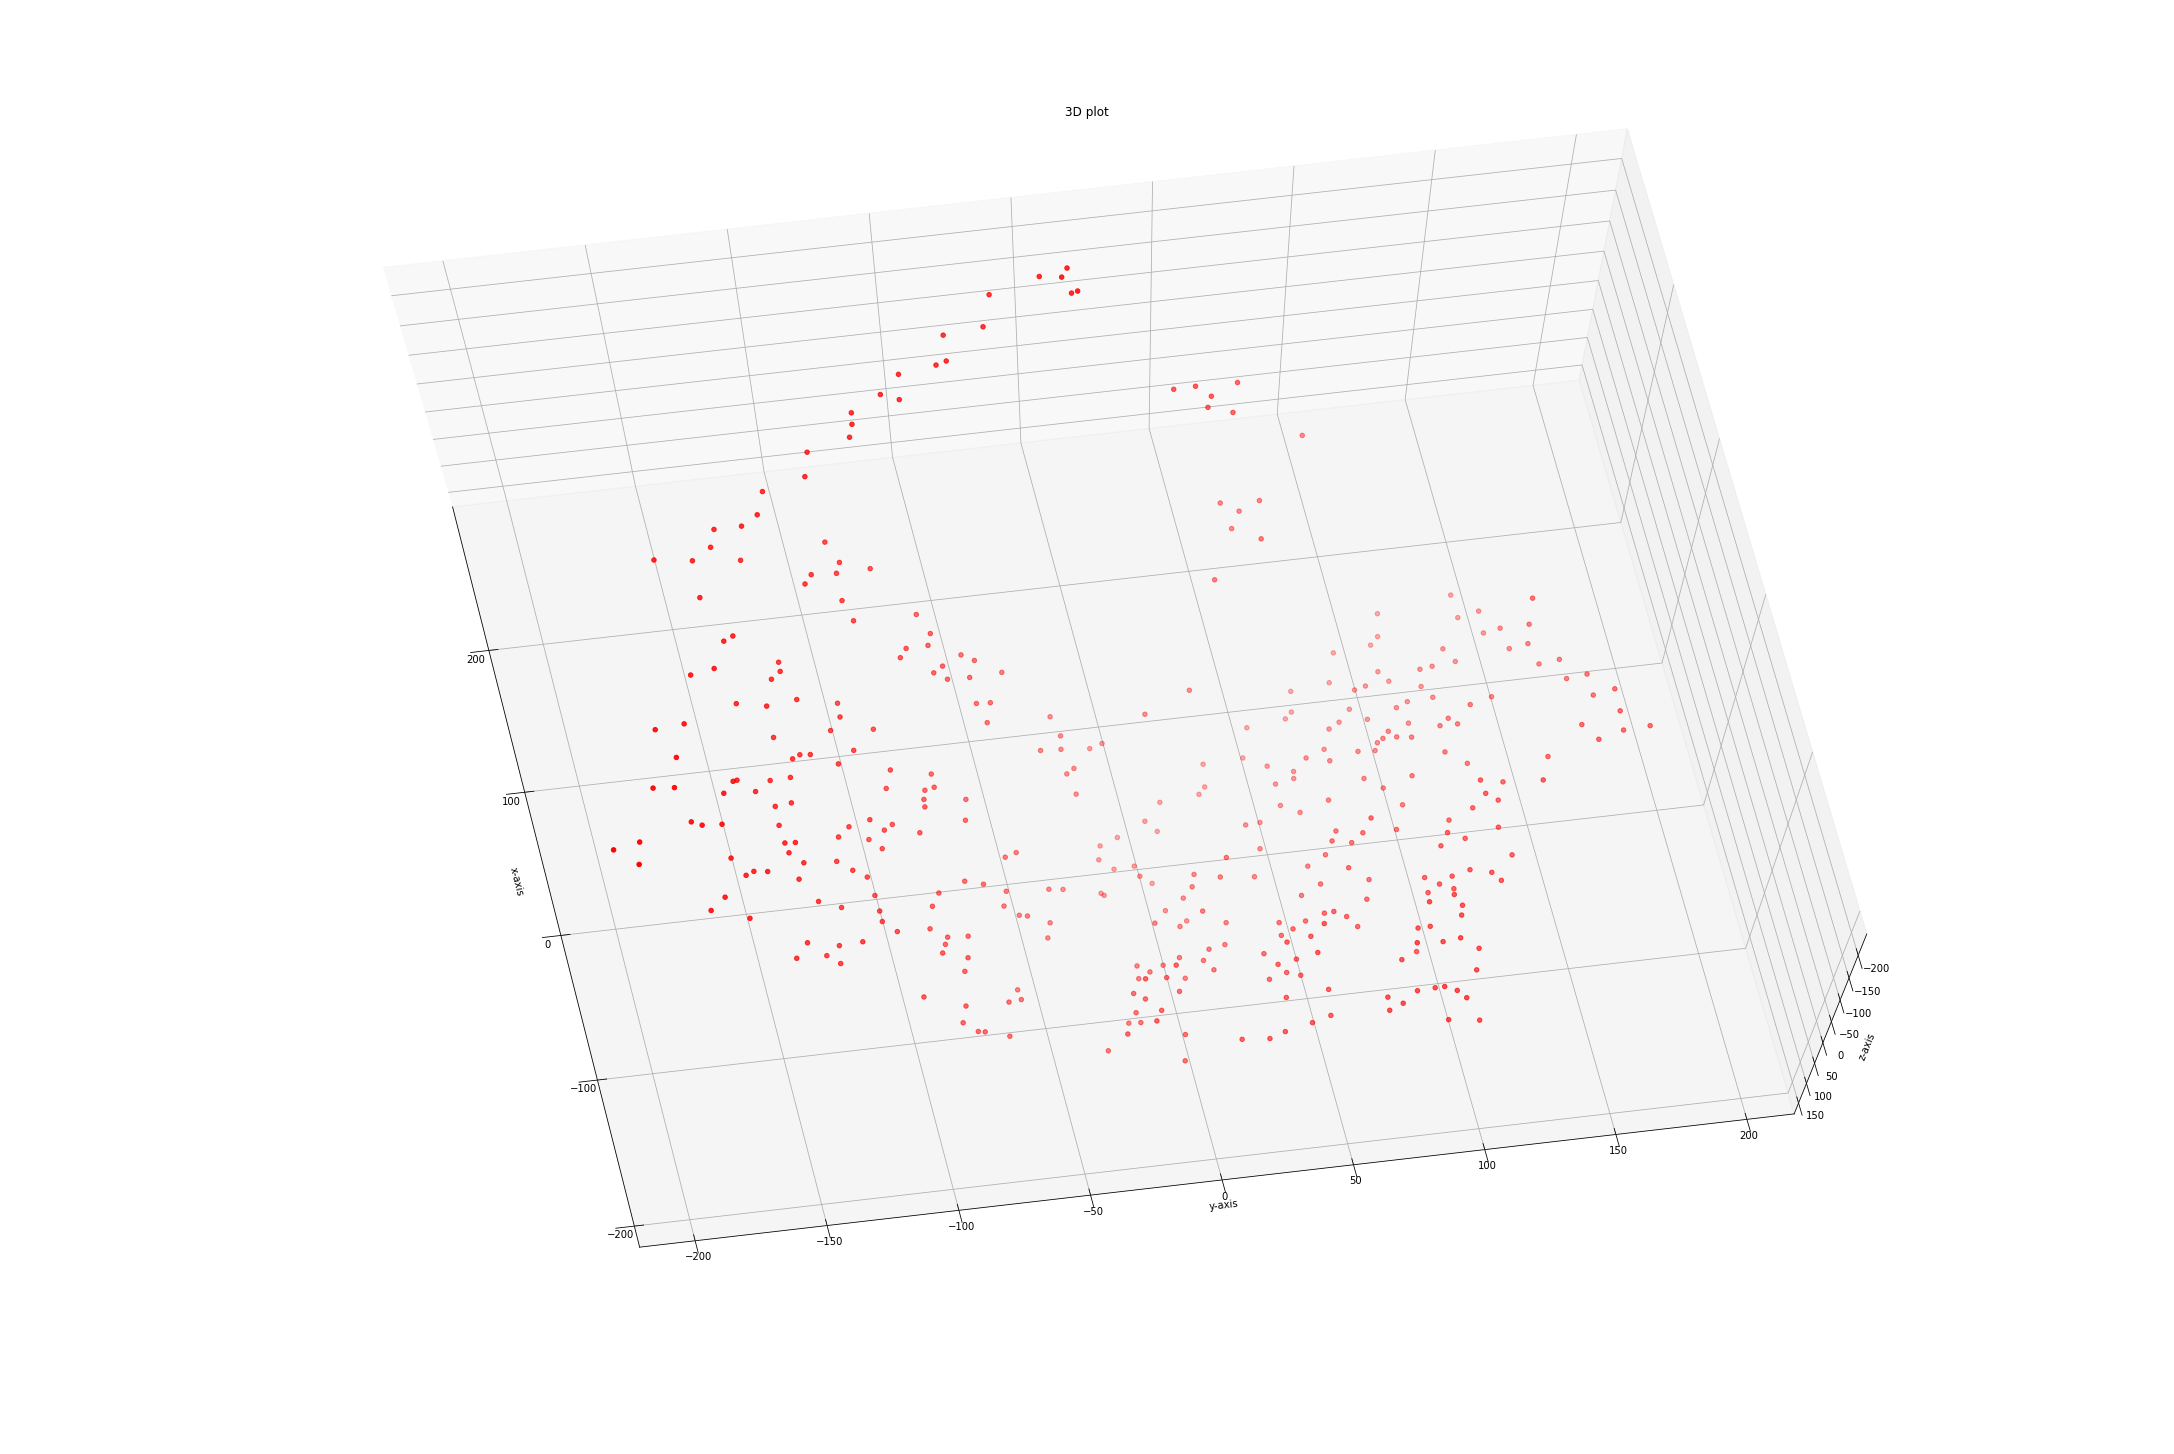

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
  
# creating the plot
plot_ = ax.scatter(X[0,:], X[1,:], X[2,:], color='red')

ax.set_title("3D plot")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
ax.view_init(255,10)
plt.show()

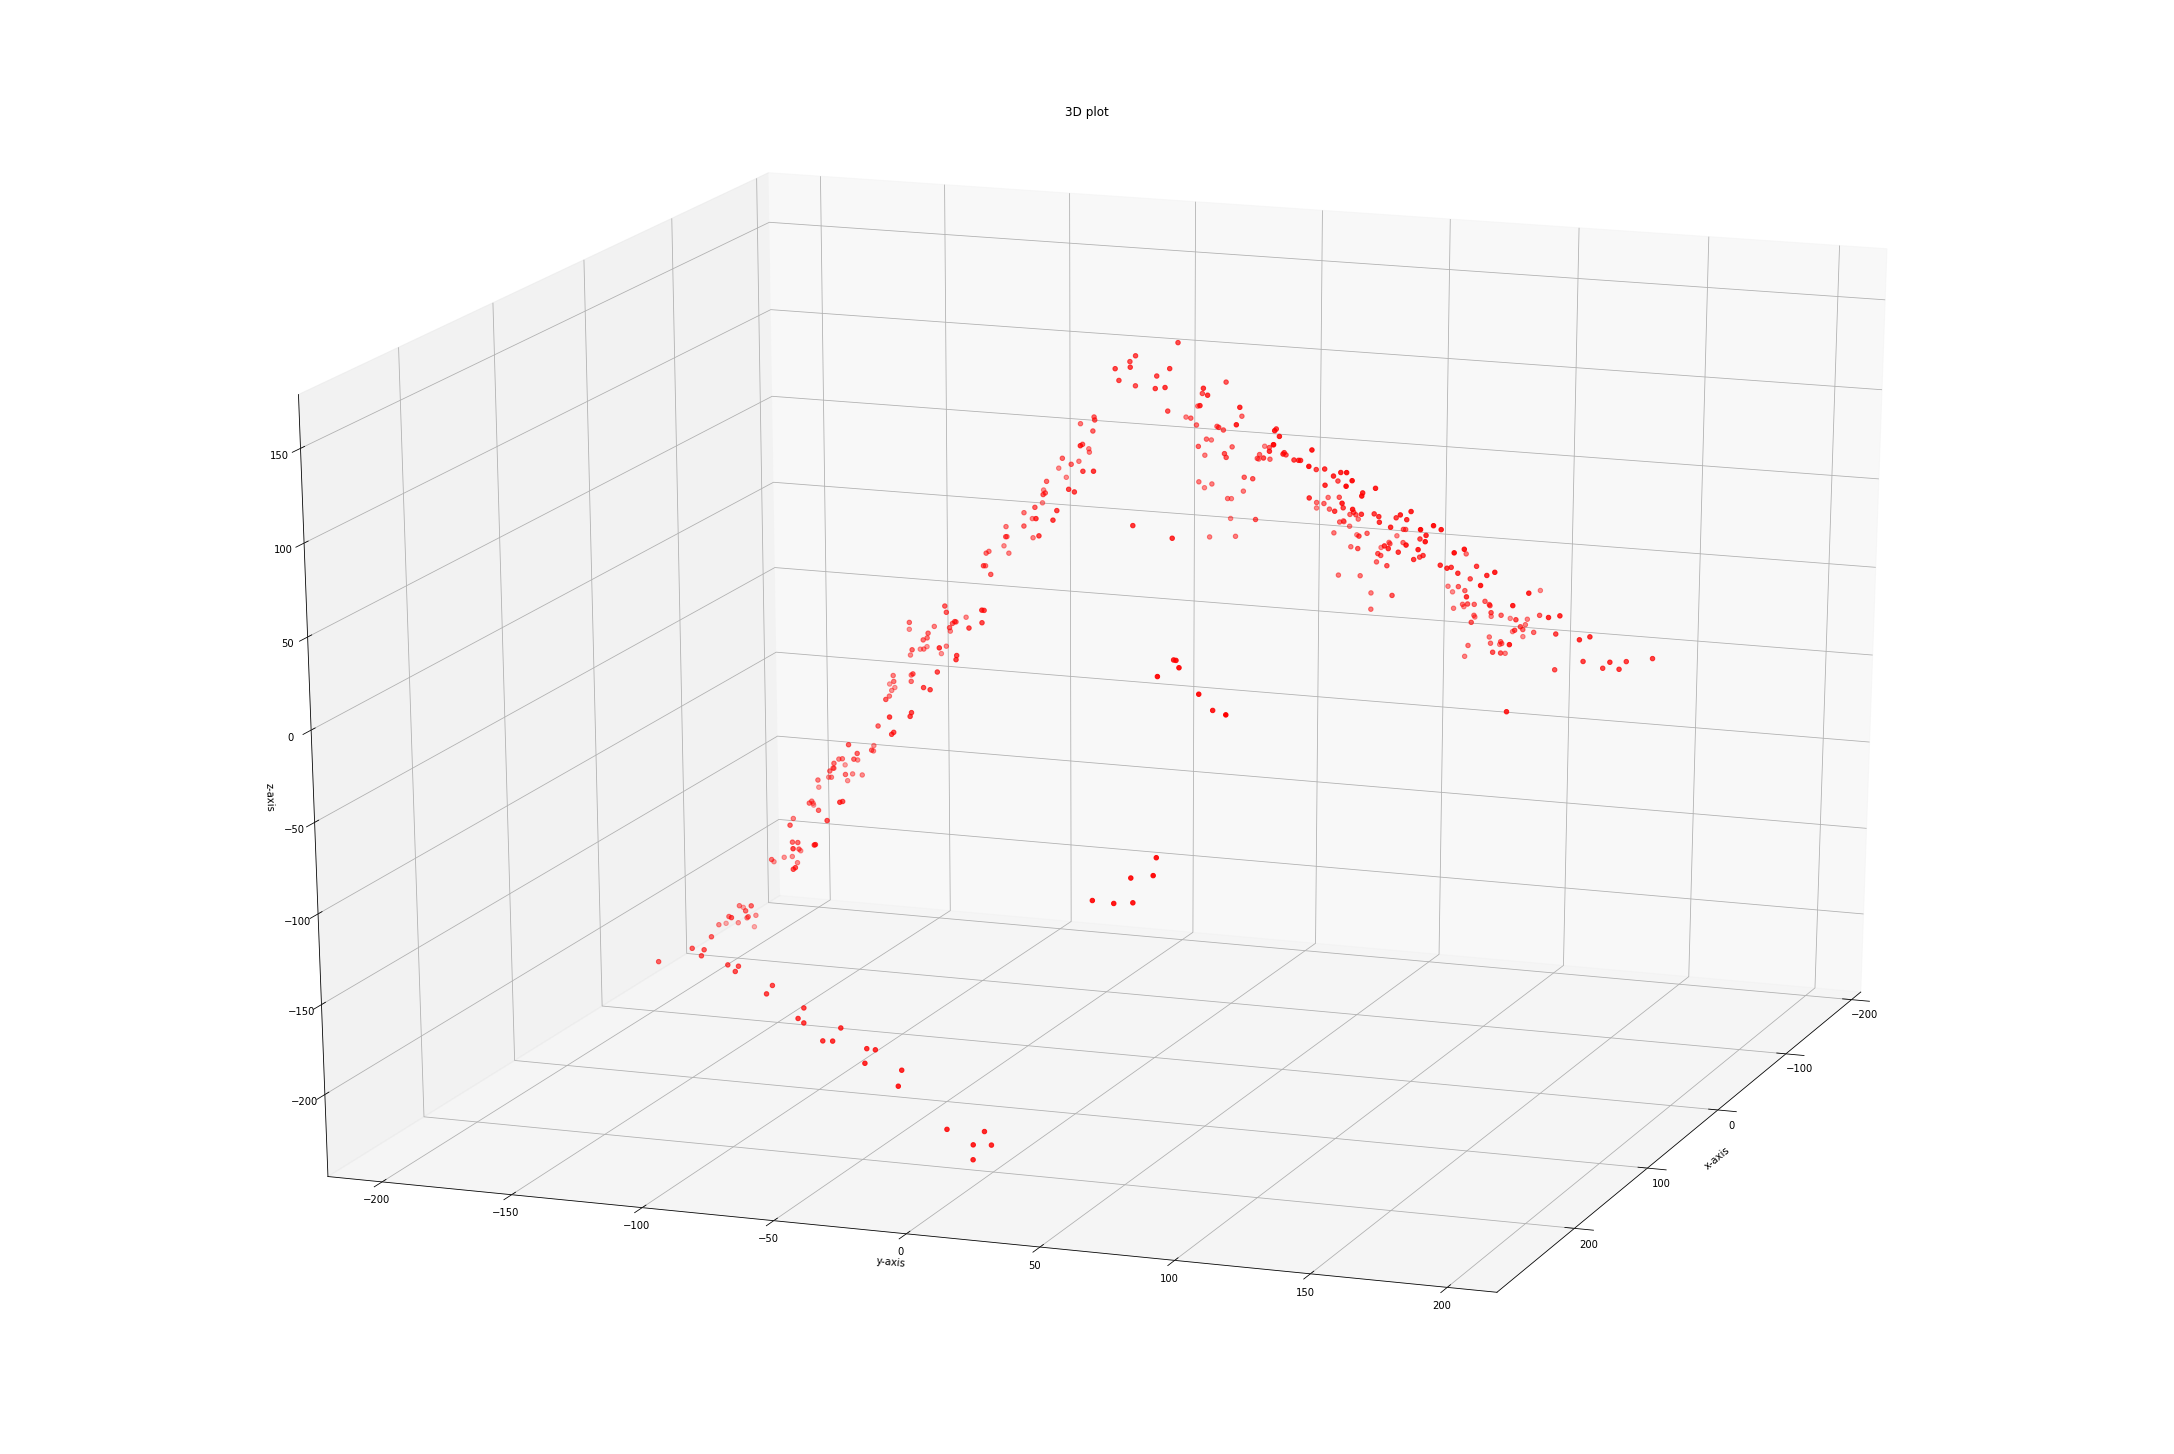

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
  
# creating the plot
plot_ = ax.scatter(X[0,:], X[1,:], X[2,:], color='red')

ax.set_title("3D plot")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
ax.view_init(azim = 20, elev = 20)
plt.show()

3D Interactive Plot - Can be visualized in Colab only

In [ ]:
import plotly.graph_objs as go

trace = go.Scatter3d(
   x = X[0,:], y = X[1,:], z = X[2,:],mode = 'markers', marker = dict(
      size = 1,
      color = 'red', # set color to an array/list of desired values
      colorscale = 'reds'
      )
   )
layout = go.Layout(title = '3D Scatter plot')
fig = go.Figure(data = [trace], layout = layout)
fig.show()